In [18]:
import random
from base64 import b64decode
from json import loads
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import sklearn
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

In [19]:
def ler(x):

    digit = loads(x)
    array = np.fromstring(b64decode(digit["data"]),dtype=np.ubyte)
    array = array.astype(np.float64)
    return (digit["label"], array)

In [20]:
with open("digits.base64.json","r") as f:
    digits = map(ler, f.readlines())
digits=list(digits)

In [21]:
def display_digit(digit, labeled = True, title = ""):
    if labeled:
        digit = digit[1]
    image = digit
    plt.figure()
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if title != "":
        plt.title("Inferred label: " + str(title))

In [22]:
new_digits=[]
cont=0
while cont<len(digits):
    new_digits.append(digits[cont][1])
    cont+=1

In [23]:
digits_treino=digits[:len(digits)*5//6]
digits_val=digits[len(digits)*5//6:]
new_digits_treino=new_digits[:len(new_digits)*5//6]
new_digits_val=new_digits[len(new_digits)*5//6:]

In [24]:
r=[]
y=[]
cont=0
while cont<len(digits):
    r.append(digits[cont][0])
    cont+=1
y=[[[0] for i in np.arange(0,10)] for j in np.arange(0,60000)]
cont=0
while cont<len(digits):
    y[cont][r[cont]][0]=1
    cont+=1

Preparations

In [25]:
cont=0
while cont<60000:
    y[cont]=np.matrix(y[cont])
    cont+=1

In [26]:
cont=0
while cont<60000:
    new_digits[cont].resize(784,1)
    new_digits[cont]=np.matrix(new_digits[cont])
    cont+=1

Neural Network

In [27]:
n1=784
n2=30
n3=10
size=[n1,n2,n3]

In [28]:
def sig(x, deriv=False):
    if deriv:
        return np.multiply(sig(x),(1-sig(x)))
    return 1/(1+np.exp(-x))

In [29]:
def feedforward(i,w,b):
    z = []
    a = []
    a.append(i)
    cont=0
    while cont<2:
        dp = np.dot(w[cont],a[cont])
        z.append(np.add(dp,b[cont]))
        var = sig(z[cont])
        a.append(var)
        cont+=1
    return a,z

In [30]:
def custox(a, cont):
    var = np.subtract(a[2],y[cont])
    var = np.linalg.norm(var)
    cx = (var**2)/2
    return cx

In [31]:
def BP(a,z,cont):
    delta=[0,0]
    #BP1
    var=np.subtract(a[2],y[cont])
    var2=sig(z[1],deriv=True)
    delta[1]=np.multiply(var,var2)
    #BP2
    var=np.dot(w[1].getT(),delta[1])
    var2=sig(z[0],deriv=True)
    delta[0]=np.multiply(var,var2)
    #BP3
    deriv_b=[]
    deriv_b.append(delta[0])
    deriv_b.append(delta[1])
    #BP4
    deriv_w = []
    deriv_w.append(np.dot(delta[0],a[0].getT()))
    deriv_w.append(np.dot(delta[1],a[1].getT()))
    return deriv_w, deriv_b

In [32]:
def mini_batch(l,w,b):
    l_deriv_w0=[]
    l_deriv_w1=[]
    l_deriv_b0=[]
    l_deriv_b1=[]
    cont=0
    while cont<len(l):
        i=new_digits[l[cont]]
        a,z = feedforward(i,w,b)
        deriv_w, deriv_b = BP(a,z,l[cont])
        l_deriv_w0.append(deriv_w[0])
        l_deriv_w1.append(deriv_w[1])
        l_deriv_b0.append(deriv_b[0])
        l_deriv_b1.append(deriv_b[1])
        cont+=1
    return l_deriv_w0,l_deriv_w1, l_deriv_b0, l_deriv_b1
        

In [33]:
def epoch(eta,w,b):
    passo=0
    todos=np.arange(0,50000)
    np.random.shuffle(todos)
    while len(todos) != 0:
        l_deriv_w0,l_deriv_w1, l_deriv_b0, l_deriv_b1 = mini_batch(todos[:100],w,b)
        todos=todos[100:]
        mean_deriv_w0=l_deriv_w0[0]
        mean_deriv_w1=l_deriv_w1[0]
        mean_deriv_b0=l_deriv_b0[0]
        mean_deriv_b1=l_deriv_b1[0]
        cont=1
        while cont < len(l_deriv_w0):
            mean_deriv_w0 = np.add(mean_deriv_w0,l_deriv_w0[cont])
            mean_deriv_w1 = np.add(mean_deriv_w1,l_deriv_w1[cont])
            mean_deriv_b0 = np.add(mean_deriv_b0,l_deriv_b0[cont])
            mean_deriv_b1 = np.add(mean_deriv_b1,l_deriv_b1[cont])
            cont+=1
        mean_deriv_w0 = np.multiply(eta/len(l_deriv_w0),mean_deriv_w0)
        mean_deriv_w1 = np.multiply(eta/len(l_deriv_w1),mean_deriv_w1)
        mean_deriv_b0 = np.multiply(eta/len(l_deriv_b0),mean_deriv_b0)
        mean_deriv_b1 = np.multiply(eta/len(l_deriv_b1),mean_deriv_b1)
        
        w[0] = np.subtract(w[0],mean_deriv_w0)
        w[1] = np.subtract(w[1],mean_deriv_w1)
        b[0] = np.subtract(b[0],mean_deriv_b0)
        b[1] = np.subtract(b[1],mean_deriv_b1)
        passo+=100
    return w,b

In [53]:
def testa(w,b):
    cont=0
    acertos=0
    while cont<10000:
        i=new_digits[cont+50000]
        a,z=feedforward(i,w,b)
        cont2=0
        m=max(a[2])
        while cont2<10:
            if m==a[2][cont2]:
                break
            cont2+=1
        if cont2==r[cont+50000]:
            acertos+=1
        cont+=1
    return acertos
        
            

In [74]:
ef=[]
conts=[]
w=[]
b=[]
w0 = np.random.randn(30,784)
w0=np.matrix(w0)
w1 = np.random.randn(10,30)
w1=np.matrix(w1)
w.append(w0)
w.append(w1)
b0 = np.random.randn(30,1)
b0=np.matrix(b0)
b1 = np.random.randn(10,1)
b1=np.matrix(b1)
b.append(b0)
b.append(b1)
cont=0
while cont<10000:
    w,b=epoch(0.3,w,b)
    ef.append(testa(w,b)/10000)
    conts.append(cont)
    cont+=1

C:\Users\User-pc\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


KeyboardInterrupt: 

In [69]:
while cont<1000:
    w,b=epoch(0.3,w,b)
    ef.append(testa(w,b)/10000)
    conts.append(cont)
    cont+=1

C:\Users\User-pc\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


KeyboardInterrupt: 

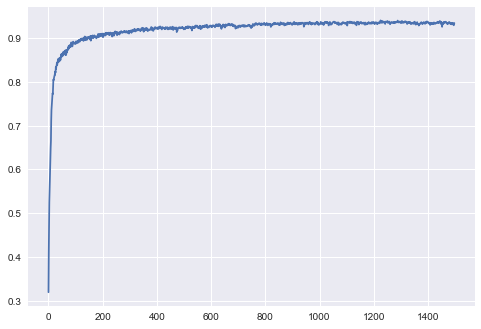

In [75]:
plt.plot(conts,ef)
plt.show()

In [78]:
ef[len(ef)-15:]

[0.934,
 0.9346,
 0.9327,
 0.9344,
 0.9325,
 0.9315,
 0.9345,
 0.9348,
 0.934,
 0.9342,
 0.9336,
 0.9303,
 0.9294,
 0.931,
 0.9345]

In [79]:
ll=[]
ll.append(w)
ll.append(b)

In [89]:
import pickle

pickle.dump([w,b], open('neural.p','wb'))

In [90]:
g,h=pickle.load(open('neural.p','rb'))

In [91]:
testa(g,h)

C:\Users\User-pc\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


9338

Tests

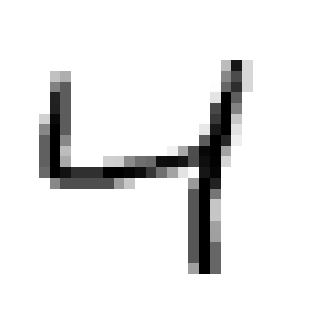

In [174]:
display_digit(digits[2])

In [180]:
r[0]

5

In [83]:
i=new_digits[0]
w=[]
b=[]
w0 = np.random.randn(30,784)
w0=np.matrix(w0)
w1 = np.random.randn(10,30)
w1=np.matrix(w1)
w.append(w0)
w.append(w1)
b0 = np.random.randn(30,1)
b0=np.matrix(b0)
b1 = np.random.randn(10,1)
b1=np.matrix(b1)
b.append(b0)
b.append(b1)

a,z=feedforward(i,w,b)

C:\Users\User-pc\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [151]:
deriv_w, deriv_b=BP(a,z,0)
deriv_b

C:\Users\User-pc\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


[matrix([[  0.00000000e+000],
         [ -0.00000000e+000],
         [  0.00000000e+000],
         [ -0.00000000e+000],
         [ -0.00000000e+000],
         [  0.00000000e+000],
         [  0.00000000e+000],
         [  0.00000000e+000],
         [  6.49309685e-268],
         [  0.00000000e+000],
         [ -0.00000000e+000],
         [ -9.25546281e-011],
         [ -3.56961903e-135],
         [  0.00000000e+000],
         [ -7.28035676e-082],
         [  0.00000000e+000],
         [ -0.00000000e+000],
         [ -2.45038612e-136],
         [ -0.00000000e+000],
         [  7.87114859e-207],
         [  0.00000000e+000],
         [  0.00000000e+000],
         [  0.00000000e+000],
         [ -0.00000000e+000],
         [  0.00000000e+000],
         [ -0.00000000e+000],
         [  1.97830563e-254],
         [  0.00000000e+000],
         [ -0.00000000e+000],
         [  0.00000000e+000]]), matrix([[ 0.0006351 ],
         [ 0.03372408],
         [ 0.07808133],
         [ 0.04269792],
   

In [103]:
matrix = [[0 for i in np.arange(0,n2)] for j in np.arange(0,n3)]
matrix=np.matrix(matrix)

matrix([[ 2.]])

In [110]:
h=[1,2,3,4,5,6]
h=np.matrix(h)
h.resize(6,1)
h

matrix([[1],
        [2],
        [3],
        [4],
        [5],
        [6]])

In [163]:
todos=np.arange(0,50000)
np.random.shuffle(todos)
todos

array([45329, 46051, 21676, ...,  1855, 31042, 32468])